# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [2]:
# As usual, a bit of setup
print "start..."
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))
print "end..."

start...
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
end...


In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000L, 3L, 32L, 32L)
X_train:  (49000L, 3L, 32L, 32L)
X_test:  (1000L, 3L, 32L, 32L)
y_val:  (1000L,)
y_train:  (49000L,)
y_test:  (1000L,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [4]:
print "start..."
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print 'Running tests with p = ', p
  print 'Mean of input: ', x.mean()
  print 'Mean of train-time output: ', out.mean()
  print 'Mean of test-time output: ', out_test.mean()
  print 'Fraction of train-time output set to zero: ', (out == 0).mean()
  print 'Fraction of test-time output set to zero: ', (out_test == 0).mean()
  print
print "end..."

start...
Running tests with p =  0.3
Mean of input:  10.0006649272
Mean of train-time output:  9.96252711285
Mean of test-time output:  10.0006649272
Fraction of train-time output set to zero:  0.701136
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.0006649272
Mean of train-time output:  10.0137475625
Mean of test-time output:  10.0006649272
Fraction of train-time output set to zero:  0.39916
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.0006649272
Mean of train-time output:  9.99078594483
Mean of test-time output:  10.0006649272
Fraction of train-time output set to zero:  0.2508
Fraction of test-time output set to zero:  0.0

end...


# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [5]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print 'dx relative error: ', rel_error(dx, dx_num)

dx relative error:  5.44561109885e-11


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

#why? b2 relative error: 2.13e-01

In [11]:
print "start..."
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print 'Running check with dropout = ', dropout
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))
  print
print "end..."

start...
Running check with dropout =  0
Initial loss:  2.30693883132
W1 relative error: 1.58e-07
W2 relative error: 3.93e-07
W3 relative error: 4.84e-08
b1 relative error: 4.92e-08
b2 relative error: 3.17e-09
b3 relative error: 7.17e-11

Running check with dropout =  0.25
Initial loss:  2.31555299005
W1 relative error: 3.52e-09
W2 relative error: 1.24e-10
W3 relative error: 6.83e-10
b1 relative error: 5.09e-10
b2 relative error: 3.33e-01
b3 relative error: 8.13e-11

Running check with dropout =  0.5
Initial loss:  2.3189703415
W1 relative error: 8.17e-08
W2 relative error: 2.65e-08
W3 relative error: 1.40e-08
b1 relative error: 8.59e-09
b2 relative error: 1.71e-09
b3 relative error: 7.98e-11

end...


# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [18]:
# Train two identical nets, one with dropout and one without
print "start...."
num_train = 500
small_data = {
  'X_train': data['X_train'], #[:num_train],
  'y_train': data['y_train'],#[:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print "droput:",dropout

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver
print "end..."

start....
droput: 0
(Iteration 1 / 12250) loss: 7.343995
(Epoch 0 / 25) train acc: 0.148000; val_acc: 0.145000
(Iteration 101 / 12250) loss: 4.022188
(Iteration 201 / 12250) loss: 3.292036
(Iteration 301 / 12250) loss: 2.146479
(Iteration 401 / 12250) loss: 1.493793
(Epoch 1 / 25) train acc: 0.455000; val_acc: 0.417000
(Iteration 501 / 12250) loss: 1.555374
(Iteration 601 / 12250) loss: 1.899175
(Iteration 701 / 12250) loss: 1.690380
(Iteration 801 / 12250) loss: 2.028094
(Iteration 901 / 12250) loss: 1.857716
(Epoch 2 / 25) train acc: 0.448000; val_acc: 0.377000
(Iteration 1001 / 12250) loss: 1.930317
(Iteration 1101 / 12250) loss: 1.652464
(Iteration 1201 / 12250) loss: 1.814752
(Iteration 1301 / 12250) loss: 1.851746
(Iteration 1401 / 12250) loss: 2.496899
(Epoch 3 / 25) train acc: 0.438000; val_acc: 0.411000
(Iteration 1501 / 12250) loss: 1.754089
(Iteration 1601 / 12250) loss: 2.367109
(Iteration 1701 / 12250) loss: 1.999152
(Iteration 1801 / 12250) loss: 2.189517
(Iteration 1901 

start...


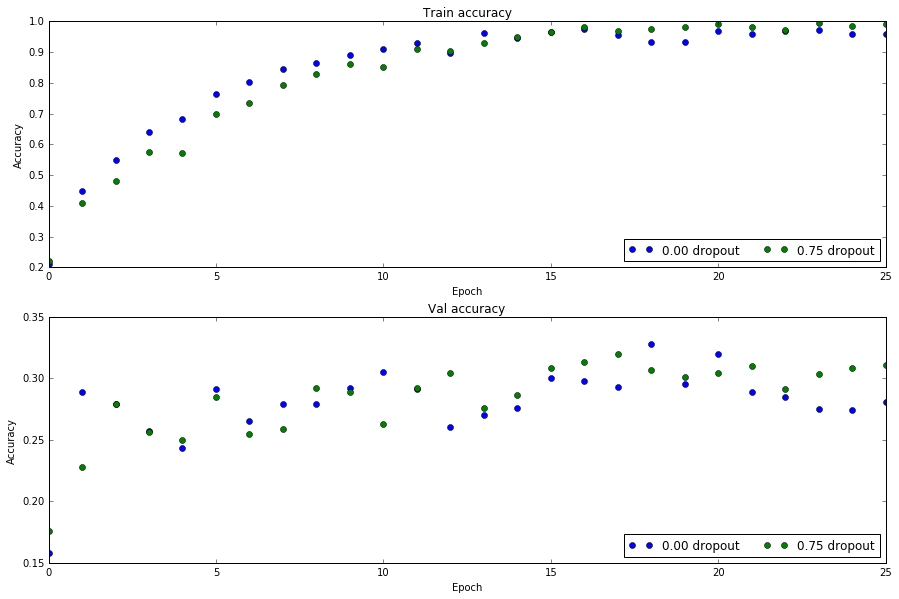

end...


In [16]:
# Plot train and validation accuracies of the two models
print "start..."
train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()
print "end..."

# Question
Explain what you see in this experiment. What does it suggest about dropout?

# Answer
generally speaking, when use dropout(e.g. dropout=0.75), validation accuracy is higher than without using droput for the same model with same hyperparameters.<br/>
it suggest that dropout is an useful tech for improve accuracy.